In [73]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import json
import numpy as np
import os
from skimage.io import imread
import matplotlib.pyplot as plt
from utils.maps_creation import calculate_sc,calculate_smooth,calculate_soft
from utils.metrics_computation import calculate_max_threshold


dir = '/datadisk/datasets/breast/expert'
expert_names = ['NP20','NP6','NP8','NP18','NP16','NP4']
files = ['A0BG_BH', 'A0DA_A7', 'A0SK_A1', 'A0YM_A2', 'A1AY_AR', 'A1LS_E2','A26Y_C8', 'A5D6_OL', 'A66I_OL', 'A73Y_LL']

In [17]:
def calculate_max_threshold(original,uncertainty_map,notall=False):
    if notall:
        original[np.argmax(uncertainty_map,axis=0)==0] = 0
    diff = original -np.argmax(uncertainty_map,axis=0) 
    diff[diff!=0] = 1
    diff[original==0] = -5
    
    cl,counts = np.unique(diff,return_counts=True)
    cl_dict = dict(zip(cl.astype(int),counts))
    good_count = cl_dict[0]
    if 1 in cl_dict.keys():
        bad_count = cl_dict[1]
    else:
        bad_count = 0
    diff[diff==0] = -5

    npr = {}
    final_max={}
    final_sum={}
    ppr = {}

    prob = 0.1
    while prob <=0.9:

        threshold = np.max(uncertainty_map,axis=0).copy()
        threshold[np.max(uncertainty_map,axis=0)>prob] = 0
        threshold[np.max(uncertainty_map,axis=0)<prob] = 1

        
        diff_a = diff - threshold 
        cl,counts = np.unique(diff_a,return_counts=True)
        cl_dict = dict(zip(cl.astype(int),counts))
        if 0 in cl_dict.keys():
            TN = cl_dict[0] # where pixels are WELL detected as bad
        else:
            TN = 0
        if -6 in cl_dict.keys():
            FN = cl_dict[-6]
        else:
            FN = 0
        
        FP = bad_count - TN
        TP = good_count - FN 
        npr[prob] = FN/(TP+FN)
        ppr[prob] = FP/(TN+FP+0.01)
        final_max[prob] = max(npr[prob],ppr[prob])

        final_sum[prob] = npr[prob]+ppr[prob]
        prob+=0.01
    return final_max,final_sum

In [ ]:
max_soft = []
max_smooth = []
max_sc = []
sum_soft = []
sum_smooth = []
sum_sc = []


for i,file in enumerate(files):

    print(f'{i}: {file}')
    weights = []
    experts = []
    for exp in expert_names:
        if os.path.isfile(f'{dir}/masks/Train/{exp}/{file}.png'):
            expert= imread(f'{dir}/masks/Train/{exp}/{file}.png')
            experts.append(expert)
            weights.append(list(np.load(f'{dir}/weights/weights_{exp}.npy')))
    print('num experts ',len(experts))
    # if len(experts)>2:
    original = imread(f'{dir}/masks/Train/expert/{file}.png')
    _,_,soft_final = calculate_soft(experts,num_cl=4)
    _,_,smooth_final = calculate_smooth(experts,num_cl=4)
    _,_,sc_final = calculate_sc(experts,weights,num_cl=4)


    try:
        max_thresh_soft,sum_thresh_soft = calculate_max_threshold(original,soft_final)
        max_soft.append(max_thresh_soft)
        sum_soft.append(sum_thresh_soft)
        max_thresh_smooth,sum_thresh_smooth = calculate_max_threshold(original,smooth_final)
        max_smooth.append(max_thresh_smooth)
        sum_smooth.append(sum_thresh_smooth)
        max_thresh_sc,sum_thresh_sc = calculate_max_threshold(original,sc_final)
        max_sc.append(max_thresh_sc)
        sum_sc.append(sum_thresh_sc)

    except:
        print(file)

0: A0BG_BH
num experts  6


/home/laura/anaconda3/envs/multi/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


1: A0YM_A2
num experts  6


/home/laura/anaconda3/envs/multi/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


2: A1AY_AR
num experts  6


/home/laura/anaconda3/envs/multi/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


3: A1LS_E2
num experts  6


/home/laura/anaconda3/envs/multi/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


4: A26Y_C8
num experts  6


/home/laura/anaconda3/envs/multi/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


5: A66I_OL
num experts  6


/home/laura/anaconda3/envs/multi/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


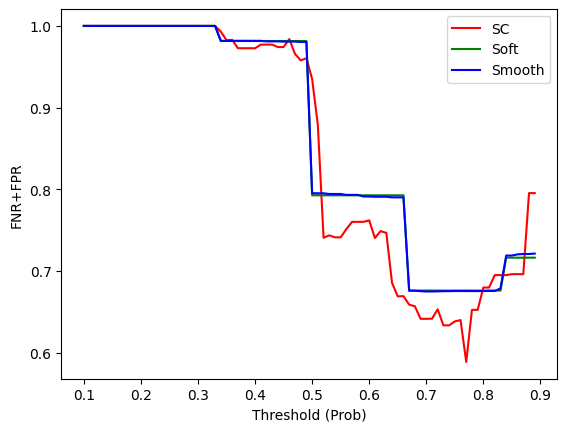

In [19]:
all_ious_sc = sum_sc[0].copy()
all_ious_soft = sum_soft[0].copy()
all_ious_smooth = sum_smooth[0].copy()

for i in range(1,len(sum_sc)):
    for key in sum_sc[i].keys():
        all_ious_sc[key] += sum_sc[i][key]
        all_ious_soft[key] += sum_soft[i][key]
        all_ious_smooth[key] += sum_smooth[i][key]

all_ious_sc = {k: v / len(sum_sc) for k, v in all_ious_sc.items()}
all_ious_soft = {k: v / len(sum_soft) for k, v in all_ious_soft.items()}
all_ious_smooth = {k: v / len(sum_smooth) for k, v in all_ious_smooth.items()}

plt.plot(list(all_ious_sc.keys()), list(all_ious_sc.values()), color='r', label='SC')
plt.plot(list(all_ious_sc.keys()), list(all_ious_soft.values()), color='g', label='Soft')
plt.plot(list(all_ious_sc.keys()), list(all_ious_smooth.values()), color='b', label='Smooth')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Threshold (Prob)")
plt.ylabel("FNR+FPR")
plt.legend()
# plt.savefig(f'results_figures/comparison_{n_experts}experts.png')
# plt.close("all")

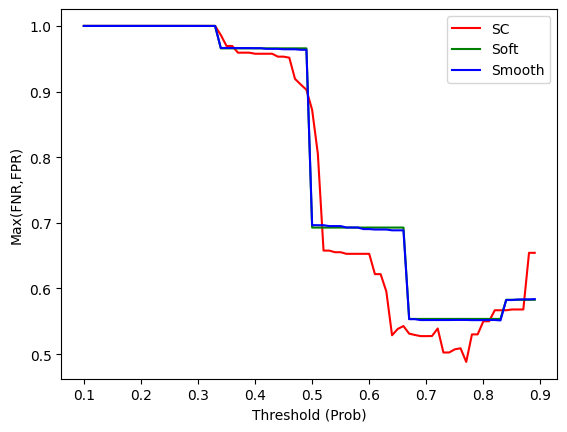

In [20]:
all_ious_sc = max_sc[0].copy()
all_ious_soft = max_soft[0].copy()
all_ious_smooth = max_smooth[0].copy()


for i in range(1,len(max_sc)):
    for key in max_sc[i].keys():
        all_ious_sc[key] += max_sc[i][key]
        all_ious_soft[key] += max_soft[i][key]
        all_ious_smooth[key] += max_smooth[i][key]

all_ious_sc = {k: v / len(max_sc) for k, v in all_ious_sc.items()}
all_ious_soft = {k: v / len(max_soft) for k, v in all_ious_soft.items()}
all_ious_smooth = {k: v / len(max_smooth) for k, v in all_ious_smooth.items()}

plt.plot(list(all_ious_sc.keys()), list(all_ious_sc.values()), color='r', label='SC')
plt.plot(list(all_ious_sc.keys()), list(all_ious_soft.values()), color='g', label='Soft')
plt.plot(list(all_ious_sc.keys()), list(all_ious_smooth.values()), color='b', label='Smooth')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Threshold (Prob)")
plt.ylabel("Max(FNR,FPR)")
plt.legend()
# plt.savefig(f'results_figures/comparison_{n_experts}experts.png')
# plt.close("all")